## POS tagging using modified Viterbi

### Data Preparation

In [55]:
#Importing libraries
import numpy as np
import pandas as pd
import time, random, pprint
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
#Reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [57]:
#Check first two lists in nltk_data list
pp = pprint.PrettyPrinter(compact=True)
pp.pprint(nltk_data[:2])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'),
  ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'),
  ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'),
  ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'),
  ('29', 'NUM'), ('.', '.')],
 [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'),
  ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'),
  ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'),
  ('.', '.')]]


In [58]:
#Split 95 train 5 validation
train_set, test_set = train_test_split(nltk_data, test_size=0.05, random_state=42)

In [59]:
#Checking length of train and test sets
print('Train set length:',len(train_set))
print('Test set length:',len(test_set))

Train set length: 3718
Test set length: 196


In [60]:
#Get all word tag tuples in single list instead of list of lists
train_tagged_words = [pair for sentence in train_set for pair in sentence]
#Check length of tagged words
print('Train Tagged words length:',len(train_tagged_words))

Train Tagged words length: 95589


In [61]:
#Check total unique words
train_words = [pair[0] for pair in train_tagged_words]
print('Train Total Unique words length:',len(set(train_words)))

Train Total Unique words length: 12109


In [62]:
#Check total unique tags
train_tags = [pair[1] for pair in train_tagged_words]
train_tags_unique = list(set(train_tags))
print('Train Total Unique tags length:',len(train_tags_unique))

Train Total Unique tags length: 12


In [63]:
#Print tags
print(train_tags_unique)

['ADV', 'DET', 'NOUN', 'ADP', 'VERB', 'CONJ', '.', 'PRON', 'X', 'NUM', 'PRT', 'ADJ']


In [64]:
#As we can see, around 28% of tags in train set are NOUN
most_common_train_tags = [(pair[0],100*(pair[1]/len(train_tags))) for pair in Counter(train_tags).most_common()]
most_common_train_tags

[('NOUN', 28.6884474154976),
 ('VERB', 13.47958447101654),
 ('.', 11.631045413175157),
 ('ADP', 9.776229482471832),
 ('DET', 8.66626913138541),
 ('X', 6.565609013589429),
 ('ADJ', 6.357426063668415),
 ('NUM', 3.5181872391174713),
 ('PRT', 3.2001590141125025),
 ('ADV', 3.148897885739991),
 ('PRON', 2.7388088587598993),
 ('CONJ', 2.2293360114657546)]

In [65]:
most_common_train_tag = most_common_train_tags[0][0]
most_common_train_tag

'NOUN'

### Build the vanilla Viterbi based POS tagger

<b>Goal</b>: Find most probable tag for a given word

<b>Solution is to use Viterbi Algorithm</b>: <br/>
Assign tag to each word sequentially based on maximum likelihood - <br/>
    <b>P(tag|word) = P(word|tag) * P(tag|previous word's tag)</b>
    
Since we find tag for words, words are what we observe, and tags will be hidden states.<br/>
Tags can <b>'transition'</b> to other tags with <b>Transition Probability</b> P(tag|previous word's tag), or <br/>
Tags can <b>'emit'</b> observations (words) with <b>Emission probability</b> P(word|tag).

<b>Time Complexity</b>: O(nT^2) : n = number of words, T = possible tags <br/>

----------------------------------------------------------------------------------------------------------------------


#### Calculate Emission Probabilities

Emission Probability: P(w|t) = count(w,t)/count(t)

In [66]:
#Function to calculate emission probabilities
def emission_probability(word, tag):
    emission_prob = 0
    tag_pairs_list = [pair for pair in train_tagged_words if pair[1]==tag]
    if len(tag_pairs_list)>0:
        word_given_tag_list = [pair[0] for pair in tag_pairs_list if pair[0]==word]
        emission_prob = len(word_given_tag_list)/len(tag_pairs_list)
    return emission_prob

In [67]:
#Test function
print('Positive test', emission_probability('Pierre', 'NOUN'))
print('Negative test', emission_probability('Pierre', 'NN'))

Positive test 3.646574043685957e-05
Negative test 0


#### Calculate Transition Probabilites

Transition Probability: P(t2|t1)=count(t2,t1)/count(t1)

In [68]:
#Function to calculate transition probabilities
def transition_probability(tag2, tag1):
    transition_prob = 0
    all_tags = [pair[1] for pair in train_tagged_words]
    count_tag1 = len([tag for tag in all_tags if tag==tag1])
    if count_tag1>0:
        count_tag2_after_tag1 = 0
        for idx in range(len(all_tags)-1):
            if all_tags[idx]==tag1 and all_tags[idx+1]==tag2:
                count_tag2_after_tag1+=1
        transition_prob=count_tag2_after_tag1/count_tag1
    return transition_prob

In [69]:
#Test function
print('Positive test', transition_probability('NOUN', 'NOUN'))
print('Negative test', transition_probability('NOUN', 'NN'))

Positive test 0.2646318783502899
Negative test 0


#### Transition Probabilities Matrix

Create a matrix to hold all transitional probabilities. <br/> 
There are only 12 unique tags. <br/>
Creating a matrix makes it easier for Viterbi algorithm to directly pick the probability instead of calculating it everytime.

In [70]:
#Matrix to hold all tags
tags_matrix = np.zeros((len(train_tags_unique), len(train_tags_unique)), dtype='float32')

for i, tag1 in enumerate(train_tags_unique):
    for j, tag2 in enumerate(train_tags_unique):
        tags_matrix[i,j]=transition_probability(tag2, tag1)

In [71]:
#Convert the matrix to dataframe for better readability
tags_df = pd.DataFrame(tags_matrix, columns = train_tags_unique, index=train_tags_unique)
tags_df.head()#top 5 rows only

,ADV,DET,NOUN,ADP,VERB,CONJ,.,PRON,X,NUM,PRT,ADJ
ADV,0.081063,0.067110,0.030897,0.119601,0.344518,0.006312,0.136877,0.015615,0.023588,0.030565,0.013621,0.130233
DET,0.012313,0.005311,0.640029,0.009054,0.038387,0.000483,0.017986,0.003742,0.045509,0.021970,0.000241,0.204973
NOUN,0.016884,0.013310,0.264632,0.176275,0.147978,0.041936,0.239179,0.004923,0.029136,0.009627,0.043832,0.012289
ADP,0.013162,0.326378,0.321776,0.017228,0.008240,0.000856,0.039486,0.069128,0.034029,0.062921,0.001498,0.105297
VERB,0.082577,0.133101,0.110904,0.090493,0.169189,0.005588,0.035312,0.036244,0.218005,0.022817,0.031121,0.064649


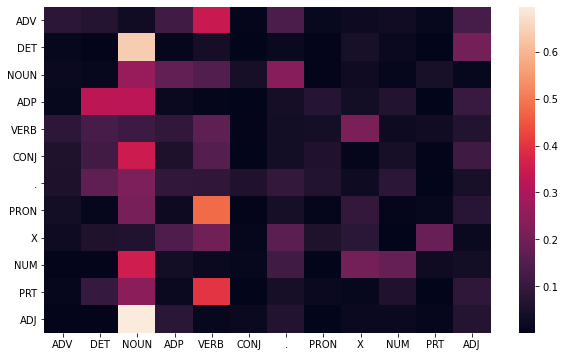

In [72]:
#Check probabilities in heatmap - Just for analysis
plt.figure(figsize=(10,6))
sns.heatmap(tags_df)
plt.show()

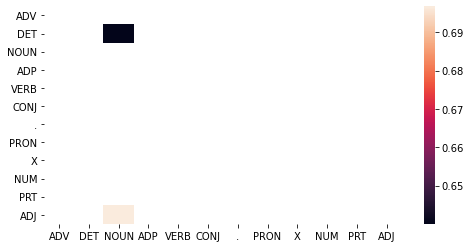

In [73]:
#Check high probabilities (>0.5) in heatmap - Just for analysis
plt.figure(figsize=(8,4))
sns.heatmap(tags_df[tags_df>0.5])
plt.show()

NOUN after DET and NOUN after ADJ looks to be highly probable

In [74]:
#Reprint using function to make sure we've correct probabilities in df
print('NOUN after DET', transition_probability('NOUN','DET'))
print('NOUN after ADJ', transition_probability('NOUN','ADJ'))

NOUN after DET 0.6400289715113472
NOUN after ADJ 0.696725357906862


#### Viterbi Algorithm

In [75]:
#Plain Vanilla Viterbi Mod
def viterbi_vanilla(words):
    start_time = time.time()
    state=[]
    
    for idx, word in enumerate(words):
        state_proba=[]
        
        for tag in train_tags_unique:
            if idx==0:
                transition_proba = tags_df.loc['.',tag]
            else:
                transition_proba = tags_df.loc[state[-1],tag]
            
            state_proba.append(emission_probability(word, tag) * transition_proba)
            
        state_proba_max = max(state_proba)
        state_max = train_tags_unique[state_proba.index(state_proba_max)] 
        state.append(state_max)
        
       
    end_time = time.time()
    print('Execution time in seconds:', end_time-start_time)
    
    return list(zip(words, state))

#### Evaluate Vanilla Viterbi Accuracy

In [76]:
#Randomly pick only top 20 test sentences, as other wise execution takes long time
random.seed(1234)
rndom = [random.randint(1,len(test_set)) for x in range(20)]

# list of sentences
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_words = [tup[0] for sent in test_run for tup in sent]

In [77]:
#Function to evaluate metrics
def get_accuracy(tagged_sequence):
    accuracy = len([i for i,j in zip(tagged_sequence, test_run_base) if i==j])/len(tagged_sequence)
    return round(accuracy*100,2)

In [78]:
#Evaluate Viterbi Vanilla
tagged_sequence_vanilla = viterbi_vanilla(test_words)
accuracy_vanilla = get_accuracy(tagged_sequence_vanilla)
print('Accuracy: Viterbi Vanilla', accuracy_vanilla)

Execution time in seconds: 100.06006383895874
Accuracy: Viterbi Vanilla 89.34


In [79]:
#Create Evaluation Metrics Dataframe
eval_metrics = pd.DataFrame(index=['Viterbi Vanilla','Viterbi Mod 1','Viterbi Mod 2'],columns=['Accuracy'])
eval_metrics = eval_metrics.fillna('To Do')

In [80]:
#Storing Viterbi Accuracy in dataframe
eval_metrics.loc['Viterbi Vanilla'] = accuracy_vanilla
eval_metrics.head()

,Accuracy
Viterbi Vanilla,89.34
Viterbi Mod 1,To Do
Viterbi Mod 2,To Do


#### Check correctly vs incorrectly tagged words

In [81]:
#Build predicted tags dataframe
sequence = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_sequence_vanilla, test_run_base))]
predicted_tags_df = pd.DataFrame()
predicted_tags_df['Previous Word']=[row[0][0] for row in sequence]
predicted_tags_df['Current Word']=[row[1][0][0] for row in sequence]
predicted_tags_df['Original tag']=[row[1][1][1] for row in sequence]
predicted_tags_df['Viterbi Vanilla tag']=[row[1][0][1] for row in sequence]
predicted_tags_df.head(10)

,Previous Word,Current Word,Original tag,Viterbi Vanilla tag
0,.,Shearson,NOUN,NOUN
1,Shearson,``,.,.
2,``,really,ADV,ADV
3,really,only,ADV,ADV
4,only,has,VERB,VERB
5,has,$,.,.
6,$,300,NUM,NUM
7,300,million,NUM,NUM
8,million,*U*,X,X
9,*U*,of,ADP,ADP


In [82]:
#Check incorrect words
incorrect_tags_df = predicted_tags_df[predicted_tags_df['Original tag']!=predicted_tags_df['Viterbi Vanilla tag']]
incorrect_tags_df.head(10)

,Previous Word,Current Word,Original tag,Viterbi Vanilla tag
21,ShareData,develops,VERB,ADV
23,and,markets,VERB,NOUN
24,markets,low-cost,ADJ,ADV
37,settled,pre-1917,ADJ,ADV
52,When,test,NOUN,VERB
57,*-1,out,ADV,PRT
69,she,copied,VERB,ADV
101,totaled,154.2,NUM,ADV
112,enormously,frustrating,VERB,ADV
128,computer,science,NOUN,ADV


#### Observations from incorrect tags

In [83]:
#Most common incorrect tags
most_common_incorrect_tag = Counter(incorrect_tags_df['Viterbi Vanilla tag']).most_common(1)[0][0]
most_common_incorrect_tag

'ADV'

In [84]:
#Tags that are incorrectly identified
incorrect_tags_df[(incorrect_tags_df['Viterbi Vanilla tag']==most_common_incorrect_tag)]['Original tag'].value_counts()

NOUN    14
VERB    11
ADJ     11
NUM      2
ADP      1
Name: Original tag, dtype: int64

In [85]:
#Check NOUN tagged incorrectly
incorrect_tags_df[(incorrect_tags_df['Viterbi Vanilla tag']==most_common_incorrect_tag) & (incorrect_tags_df['Original tag']=='NOUN')].head()
#If unknown word start with a capital letter, mark it as NOUN - Handle in Regex

,Previous Word,Current Word,Original tag,Viterbi Vanilla tag
128,computer,science,NOUN,ADV
136,another,Walkman,NOUN,ADV
150,sell,TXO,NOUN,ADV
233,the,insurgents,NOUN,ADV
247,the,Iran-Contra,NOUN,ADV


In [86]:
#Check VERB tagged incorrectly
incorrect_tags_df[(incorrect_tags_df['Viterbi Vanilla tag']==most_common_incorrect_tag) & (incorrect_tags_df['Original tag']=='VERB')].head(10)
#If unknown word start ends in 'ing','ed', mark it as VERB - Handle in Regex

,Previous Word,Current Word,Original tag,Viterbi Vanilla tag
21,ShareData,develops,VERB,ADV
69,she,copied,VERB,ADV
112,enormously,frustrating,VERB,ADV
134,to,invent,VERB,ADV
145,was,soliciting,VERB,ADV
223,but,brushed,VERB,ADV
228,*,renewing,VERB,ADV
251,*-1,Funded,VERB,ADV
307,n't,noticed,VERB,ADV
314,*-1,Funded,VERB,ADV


In [87]:
#A hiphen in word - should be tagged as ADJ - handle with Regex
incorrect_tags_df[incorrect_tags_df['Current Word'].str.contains('-')]

,Previous Word,Current Word,Original tag,Viterbi Vanilla tag
24,markets,low-cost,ADJ,ADV
37,settled,pre-1917,ADJ,ADV
176,of,manmade-fiber,ADJ,ADV
247,the,Iran-Contra,NOUN,ADV
419,estimated,seven-million-ton,ADJ,ADV
443,a,low-tech,ADJ,ADV


#### Action based on observations of incorrect tags

Handle below with Regex Tagger:
1. If unknown word start with a capital letter, mark it as NOUN
2. If unknown word start ends in 'ing','ed', mark it as VERB
3. A hiphen in word - should be tagged as ADJ

### Method 1 - Handle Unknown Words

In Vanilla Viterbi, since emission probability is 0 for an unknown word, the algorithm is just picking up the first tag. <br/> In first modification to Viterbi, we will handle cases where when emission probability is 0.<br/>
Make state probability <b>solely depend on transition probability when emission probability is 0</b>.<br/> 

In [88]:
#Viterbi Modification 1 with handling of zero emission probabilities
#Only transition probability will drive the tag determination in this method
def viterbi_mod1(words):
    start_time = time.time()
    state=[]
    
    for idx, word in enumerate(words):
        state_proba=[]
        tran_proba=[]
        
        for tag in train_tags_unique:
            if idx==0:
                transition_proba = tags_df.loc['.',tag]
            else:
                transition_proba = tags_df.loc[state[-1],tag]
            
            state_proba.append(emission_probability(word, tag) * transition_proba)
            tran_proba.append(transition_proba)
            
        state_proba_max = max(state_proba)
        if state_proba_max==0:
            tran_proba_max = max(tran_proba)
            state_max = train_tags_unique[tran_proba.index(tran_proba_max)] 
        else:    
            state_max = train_tags_unique[state_proba.index(state_proba_max)] 
        
        state.append(state_max)
    
    end_time = time.time()
    print('Execution time in seconds:', end_time-start_time)
    
    return list(zip(words, state))

In [89]:
#Evaluate Viterbi Mod 1
tagged_sequence_mod1 = viterbi_mod1(test_words)
accuracy_mod1 = get_accuracy(tagged_sequence_mod1)
print('Accuracy: Viterbi Mod 1', accuracy_mod1)

Execution time in seconds: 100.93686294555664
Accuracy: Viterbi Mod 1 93.03


In [90]:
#Storing Viterbi Mod 1 Accuracy in dataframe
eval_metrics.loc['Viterbi Mod 1'] = accuracy_mod1
eval_metrics.head()

,Accuracy
Viterbi Vanilla,89.34
Viterbi Mod 1,93.03
Viterbi Mod 2,To Do


In [91]:
#Build Predicted tags dataframe
predicted_tags_df['Viterbi Mod 1 tag']=[pair[1] for pair in tagged_sequence_mod1]

#### Difference between mod 1 and Vanilla Viterbi

In [92]:
#Below tags were correctly predicted by mod 1, which vanilla failed predicting
mod1_corrections_df = predicted_tags_df[(predicted_tags_df['Original tag']==predicted_tags_df['Viterbi Mod 1 tag']) & (predicted_tags_df['Original tag']!=predicted_tags_df['Viterbi Vanilla tag'])]
mod1_corrections_df.head(10)

,Previous Word,Current Word,Original tag,Viterbi Vanilla tag,Viterbi Mod 1 tag
69,she,copied,VERB,ADV,VERB
112,enormously,frustrating,VERB,ADV,VERB
128,computer,science,NOUN,ADV,NOUN
134,to,invent,VERB,ADV,VERB
136,another,Walkman,NOUN,ADV,NOUN
224,brushed,off,PRT,ADP,PRT
228,*,renewing,VERB,ADV,VERB
233,the,insurgents,NOUN,ADV,NOUN
247,the,Iran-Contra,NOUN,ADV,NOUN
251,*-1,Funded,VERB,ADV,VERB


### Method 2 - Handle Unknown Words

In Vanilla Viterbi, since emission probability is 0 for an unknown word, the algorithm is just picking up the first tag. <br/> In Second modification to Viterbi, we will handle cases where when emission probability is 0.<br/>
Assign tags to unknown words using <b>Regular Expression Tagger.</b> <br/> 

In [93]:
#Viterbi Modification 2 with handling of zero emission probabilities
#Regex Tagger will determine the tags for unknown words
def viterbi_mod2(words):
    start_time = time.time()
    state=[]
    
    patterns = [ 
        (r'(?=\S*[''-])([a-zA-Z''-]+)','ADJ'),#word containing hiphen
        (r'[aA-zZ]+(ed|ing|es)$', 'VERB'),#ends with ed in es
        (r'^[A-Z][aA-zZ]*','NOUN'),#Starts with capital letter
        (r'^(0|[1-9][0-9]*)$','NUM'),#Numbers
        (r'.*','NOUN')#assign most common tag to unknown word when nothing else matches
    ]
    
    # reg ex tagger
    tagger = nltk.RegexpTagger(patterns)
    
    for idx, word in enumerate(words):
        state_proba=[]
        
        for tag in train_tags_unique:
            if idx==0:
                transition_proba = tags_df.loc['.',tag]
            else:
                transition_proba = tags_df.loc[state[-1],tag]
            
            state_proba.append(emission_probability(word, tag) * transition_proba)
            
        state_proba_max = max(state_proba)
        if state_proba_max==0:
            state_max = tagger.tag_sents([[(word)]])[0][0][1] #Tag uknown words via tagger
        else:    
            state_max = train_tags_unique[state_proba.index(state_proba_max)] 
        
        state.append(state_max)
    
    end_time = time.time()
    print('Execution time in seconds:', end_time-start_time)
    
    return list(zip(words, state))

In [94]:
#Evaluate Viterbi Mod 2 - Use Regex tagger for cases when emission probability is zero
tagged_sequence_mod2 = viterbi_mod2(test_words)
accuracy_mod2 = get_accuracy(tagged_sequence_mod2)
print('Accuracy: Viterbi Mod 2', accuracy_mod2)

Execution time in seconds: 100.58340549468994
Accuracy: Viterbi Mod 2 94.88


In [95]:
#Storing Viterbi Mod 2 Accuracy in dataframe
eval_metrics.loc['Viterbi Mod 2'] = accuracy_mod2
eval_metrics.head()

,Accuracy
Viterbi Vanilla,89.34
Viterbi Mod 1,93.03
Viterbi Mod 2,94.88


In [96]:
#Build Predicted tags dataframe
predicted_tags_df['Viterbi Mod 2 tag']=[pair[1] for pair in tagged_sequence_mod2]

#### Difference between mod 2 and Vanilla Viterbi

In [97]:
#Below tags were correctly predicted by mod 2, which vanilla and mod 1 failed predicting
mod2_corrections_df = predicted_tags_df[(predicted_tags_df['Original tag']==predicted_tags_df['Viterbi Mod 2 tag']) & (predicted_tags_df['Original tag']!=predicted_tags_df['Viterbi Mod 1 tag']) & (predicted_tags_df['Original tag']!=predicted_tags_df['Viterbi Vanilla tag'])]
mod2_corrections_df.head(10)

,Previous Word,Current Word,Original tag,Viterbi Vanilla tag,Viterbi Mod 1 tag,Viterbi Mod 2 tag
24,markets,low-cost,ADJ,ADV,NOUN,ADJ
37,settled,pre-1917,ADJ,ADV,X,ADJ
145,was,soliciting,VERB,ADV,X,VERB
150,sell,TXO,NOUN,ADV,X,NOUN
176,of,manmade-fiber,ADJ,ADV,DET,ADJ
183,$,405,NUM,ADV,NOUN,NUM
223,but,brushed,VERB,ADV,NOUN,VERB
261,from,Tokio,NOUN,ADV,DET,NOUN
324,from,Tokio,NOUN,ADV,DET,NOUN
419,estimated,seven-million-ton,ADJ,ADV,X,ADJ


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [98]:
#Evaluation Metrics shows the accuracy for different algorithms
eval_metrics.head()

,Accuracy
Viterbi Vanilla,89.34
Viterbi Mod 1,93.03
Viterbi Mod 2,94.88


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [99]:
#Below dataframe contains all the predicted tags
predicted_tags_df.head()

,Previous Word,Current Word,Original tag,Viterbi Vanilla tag,Viterbi Mod 1 tag,Viterbi Mod 2 tag
0,.,Shearson,NOUN,NOUN,NOUN,NOUN
1,Shearson,``,.,.,.,.
2,``,really,ADV,ADV,ADV,ADV
3,really,only,ADV,ADV,ADV,ADV
4,only,has,VERB,VERB,VERB,VERB


In [100]:
#Apply conditions to filter rows where Vanilla Viterbi Incorrectly tagged the words
vanilla_viterbi_incorrect_prediction_df = predicted_tags_df[predicted_tags_df['Original tag']!=predicted_tags_df['Viterbi Vanilla tag']]

In [101]:
#Determine ones that are correctly predicted by both mod 1 and mod 2, but not by vanilla viterbi
prediction_corrections_df = vanilla_viterbi_incorrect_prediction_df[(vanilla_viterbi_incorrect_prediction_df['Original tag']==vanilla_viterbi_incorrect_prediction_df['Viterbi Mod 1 tag']) & (vanilla_viterbi_incorrect_prediction_df['Original tag']==vanilla_viterbi_incorrect_prediction_df['Viterbi Mod 2 tag'])]
prediction_corrections_df

,Previous Word,Current Word,Original tag,Viterbi Vanilla tag,Viterbi Mod 1 tag,Viterbi Mod 2 tag
69,she,copied,VERB,ADV,VERB,VERB
112,enormously,frustrating,VERB,ADV,VERB,VERB
128,computer,science,NOUN,ADV,NOUN,NOUN
136,another,Walkman,NOUN,ADV,NOUN,NOUN
224,brushed,off,PRT,ADP,PRT,PRT
228,*,renewing,VERB,ADV,VERB,VERB
233,the,insurgents,NOUN,ADV,NOUN,NOUN
251,*-1,Funded,VERB,ADV,VERB,VERB
273,medical,protocols,NOUN,ADV,NOUN,NOUN
287,prospective,acquirers,NOUN,ADV,NOUN,NOUN


Above words were incorrectly tagged by Vanilla Viterbi, but were corrected by both mod 1 and mod 2

### Unknown words corpus - Test

In [102]:
unknown_words_corpus = """Android is a mobile operating system developed by Google.
Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
Before entering politics, Donald Trump was a domineering businessman and a television personality.
The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.
This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
Show me the cheapest round trips from Dallas to Atlanta
I would like to see flights from Denver to Philadelphia.
Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.
NASA invited social media users to experience the launch of ICESAT-2 Satellite."""

In [103]:
unknown_words = word_tokenize(unknown_words_corpus)
len(unknown_words)

181

In [104]:
#Create a function for easy access to various algorithms that we created in this notebook

#Input Parameters:
#Pass first param as list of words
#Do not pass second param to run vanilla viterbi
#Pass second param as 1 to run mod 1 (Transition probabilties driver)
#Pass second param as 2 to run mod 2 (Trigam backed by Regex)
#Pass second param as 3 to run all 3 algorithms in one go

#Returns:
#A dataframe of Words along with tags

def run_viterbi(words , mod=0):
    predicted_tag_sequences = []
    pred_df = pd.DataFrame()
    
    if mod==1:
        predicted_tag_sequences = viterbi_mod1(words)
        pred_df['word']=[pair[0] for pair in predicted_tag_sequences]
        pred_df['mod 1']=[pair[1] for pair in predicted_tag_sequences]
    elif mod==2:
        predicted_tag_sequences = viterbi_mod2(words)
        pred_df['word']=[pair[0] for pair in predicted_tag_sequences]
        pred_df['mod 2']=[pair[1] for pair in predicted_tag_sequences]
    elif mod==3:#Run all 3 algos at once
        predicted_tag_sequences = viterbi_vanilla(words)
        pred_df['word']=[pair[0] for pair in predicted_tag_sequences]
        pred_df['vanilla']=[pair[1] for pair in predicted_tag_sequences]
        predicted_tag_sequences = viterbi_mod1(words)
        pred_df['mod 1']=[pair[1] for pair in predicted_tag_sequences]
        predicted_tag_sequences = viterbi_mod2(words)
        pred_df['mod 2']=[pair[1] for pair in predicted_tag_sequences]
    else:#By default run Vanilla Viterbi
        predicted_tag_sequences = viterbi_vanilla(words)
        pred_df['word']=[pair[0] for pair in predicted_tag_sequences]
        pred_df['vanilla']=[pair[1] for pair in predicted_tag_sequences]
    
    
    return pred_df

In [105]:
result_df = run_viterbi(unknown_words, mod=3)
result_df.head()

Execution time in seconds: 36.795313596725464
Execution time in seconds: 36.813554525375366
Execution time in seconds: 36.877341508865356


,word,vanilla,mod 1,mod 2
0,Android,ADV,NOUN,NOUN
1,is,VERB,VERB,VERB
2,a,DET,DET,DET
3,mobile,ADJ,ADJ,ADJ
4,operating,NOUN,NOUN,NOUN


In [106]:
#Check the predictions differences between methods
result_df[(result_df['vanilla']!=result_df['mod 1']) | (result_df['vanilla']!=result_df['mod 2'])]

,word,vanilla,mod 1,mod 2
0,Android,ADV,NOUN,NOUN
8,Google,ADV,DET,NOUN
10,Android,ADV,NOUN,NOUN
15,OS,ADV,NOUN,NOUN
16,worldwide,ADV,NOUN,NOUN
18,smartphones,ADV,DET,VERB
20,2011,ADV,DET,NUM
25,2013,ADV,DET,NUM
27,Google,ADV,NOUN,NOUN
29,Twitter,ADV,NOUN,NOUN


viterbi_mod2 seems like best algo for POS tagging, based on above results and accuracy data